In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import csv
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import re
import seaborn as sns
import japanize_matplotlib
import sqlite3
import matplotlib.pyplot as plt

In [111]:
# スクレイピング対象のURL
url = [
    'https://type.jp/rank/', # 総合
    'https://type.jp/rank/development/', # 開発エンジニア
    'https://type.jp/rank/pm/', # PM/PL/ITコンサル
    'https://type.jp/rank/infrastructure/', # インフラ系エンジニア
    'https://type.jp/rank/engineer/', # その他ITエンジニア
    'https://type.jp/rank/sales/', # 営業
    'https://type.jp/rank/service/', # サービス・販売
    'https://type.jp/rank/office/' # オフィスワーク
]

In [ ]:
def get_category_from_url(url):
    """URLから職種カテゴリーを判断"""
    category_mapping = {
        '/rank/development/': '開発エンジニア',
        '/rank/pm/': 'PM/PL/ITコンサル',
        '/rank/infrastructure/': 'インフラ系エンジニア',
        '/rank/engineer/': 'その他ITエンジニア',
        '/rank/sales/': '営業',
        '/rank/service/': '販売・サービス',
        '/rank/office/': '事務',
        '/rank/': '総合'
    }

    for path, category in category_mapping.items():
        if path in url:
            return category
    return '不明'

def get_job_urls_from_ranking(ranking_url):
    try:
        print(f"ランキングページにアクセス中: {ranking_url}")

        session = requests.Session()
        response = session.get(ranking_url, headers=headers, timeout=30)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        # カテゴリーを取得
        category = get_category_from_url(ranking_url)
        print(f"現在の職種カテゴリー: {category}")

        # 求人情報を含む要素を検索
        job_data = []
        job_items = soup.find_all('div', class_='mod-job-info-left')

        print(f"検出された求人アイテム数: {len(job_items)}")

        for rank, item in enumerate(job_items[:20], 1):
            try:
                # 求人リンクの取得
                link_elem = item.find('a', href=True)
                if link_elem:
                    link = link_elem.get('href')
                    full_url = 'https://type.jp' + link if not link.startswith('http') else link

                # 企業名の取得
                company_name_candidates = [
                    item.find('p', class_='company'),
                    item.find('div', class_='company'),
                    item.find('span', class_='company')
                ]

                company_name = None
                for candidate in company_name_candidates:
                    if candidate and candidate.text.strip():
                        company_name = candidate.text.strip()
                        break
                
                if not company_name:
                    company_name = "企業名なし"

                # 給与情報の取得
                info_right = item.find_next('div', class_='mod-job-info-right')
                if info_right:
                    salary_elem = info_right.find(['p', 'span'], class_=['data']) or \
                                  info_right.find(['p', 'span'], text=lambda x: x and '万円' in str(x))
                    salary = salary_elem.text.strip() if salary_elem else "給与情報なし"
                else:
                    salary = "給与情報なし"

                job_data.append({
                    'url': full_url,
                    'rank': rank,
                    'category': category,
                    'company_name': company_name,
                    'salary': salary
                })

                print(f"\n求人情報を取得: Rank {rank}")
                print(f"カテゴリー: {category}")
                print(f"企業名: {company_name}")
                print(f"URL: {full_url}")
                print(f"給与: {salary}")

            except Exception as e:
                print(f"個別求人の処理でエラー (Rank {rank}): {str(e)}")

        return job_data

    except Exception as e:
        print(f"ランキングページの処理でエラー: {str(e)}")
        return []

def get_company_info(job_url):
    try:
        print(f"求人ページにアクセス中: {job_url}")

        session = requests.Session()
        response = session.get(job_url, headers=headers, timeout=30)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        # 企業情報を含む要素を探す
        company_info = {
            'company_name': "情報なし",
            'established': "情報なし",
            'employees': "情報なし",
            'capital': "情報なし"
        }

        # 企業名の取得
        company_elem = (
            soup.find('p', class_='corp-name') or
            soup.find('span', class_='company') or
            soup.find(['h1', 'h2'], class_=['company', 'corp-name'])
        )
        if company_elem:
            company_info['company_name'] = company_elem.text.strip()

        # 設立、従業員数、資本金を含む要素を探す
        company_info_section = soup.find('section', class_='bigarea kigyogaiyo mod-job-detail mod-company-info')
        if company_info_section:
            dt_dd_pairs = company_info_section.find_all('dl')
            for pair in dt_dd_pairs:
                dt = pair.find('dt').text.strip()
                dd = pair.find('dd').text.strip()

                if dt == '設立':
                    company_info['established'] = dd
                elif dt == '従業員数':
                    employees = pair.find('p').text.strip()
                    company_info['employees'] = employees
                elif dt == '資本金':
                    company_info['capital'] = dd

        if company_info['company_name'] == "情報なし":
            breadcrumbs = soup.find('ol', class_='breadcrumbs')
            if breadcrumbs:
                last_crumb = breadcrumbs.find_all('li')[-1].find('span').text.strip()
                company_info['company_name'] = last_crumb

        return company_info

    except Exception as e:
        print(f"求人ページの処理でエラー: {str(e)}")
        return None

def write_to_csv(data):
    try:
        filename = 'job_ranking_data.csv'
        file_exists = os.path.isfile(filename)

        with open(filename, 'a', newline='', encoding='utf-8-sig') as f:
            writer = csv.DictWriter(f, fieldnames=['企業名', '順位', 'カテゴリー', '年収', '設立', '従業員数', '資本金'])

            if not file_exists:
                writer.writeheader()

            for item in data:
                formatted_data = {
                    '企業名': item.get('company_name', '情報なし'),
                    '順位': item['rank'],
                    'カテゴリー': item['category'],
                    '年収': item.get('salary', '情報なし'),
                    '設立': item.get('established', '情報なし'),
                    '従業員数': item.get('employees', '情報なし'),
                    '資本金': item.get('capital', '情報なし')
                }
                writer.writerow(formatted_data)
                print(f"データを書き込み: {formatted_data}")

        print(f"\nデータを {filename} に保存しました")

    except Exception as e:
        print(f"CSV書き込み時にエラー: {str(e)}")

def main():
    all_data = []

    for ranking_url in url:
        print(f"\n{'='*50}")
        print(f"ランキングページの処理開始: {ranking_url}")
        time.sleep(3)

        # ランキングページから求人URLを取得
        job_data = get_job_urls_from_ranking(ranking_url)

        if job_data:
            print(f"\n{len(job_data)}件の求人情報を取得しました")
            # 各求人について企業情報を取得
            for job in job_data:
                time.sleep(2)
                company_info = get_company_info(job['url'])

                if company_info:
                    # 企業情報をjobデータに統合
                    job.update(company_info)
                    all_data.append(job)
                    print(f"企業情報を取得: {company_info['company_name']}")
        else:
            print(f"\n{ranking_url} からデータを取得できませんでした")

    # 収集したデータをCSVに保存
    if all_data:
        write_to_csv(all_data)
        print(f"\n合計 {len(all_data)}件 のデータを収集しました")
    else:
        print("\nデータを収集できませんでした")

In [115]:
if __name__ == "__main__":
    main()


ランキングページの処理開始: https://type.jp/rank/
ランキングページにアクセス中: https://type.jp/rank/
現在の職種カテゴリー: 総合
検出された求人アイテム数: 20

求人情報を取得: Rank 1
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-7/1343510_detail/
給与: 350～600万円

求人情報を取得: Rank 2
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-11/1343474_detail/
給与: 250～750万円

求人情報を取得: Rank 3
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-7/1343441_detail/
給与: 350～1000万円

求人情報を取得: Rank 4
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-1/1023402_detail/
給与: 給与情報なし

求人情報を取得: Rank 5
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-1/1300937_detail/
給与: 給与情報なし

求人情報を取得: Rank 6
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-1/1307769_detail/
給与: 250～1400万円

求人情報を取得: Rank 7
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-7/1343563_detail/
給与: 300～600万円

求人情報を取得: Rank 8
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-7/1341723_detail/
給与: 300～600万円

求人情報を取得: Rank 9
カテゴリー: 総合
企業名: 企業名なし
URL: https://type.jp/job-7/1312221_detail/
給与: 350～800万円

求人情報を取得: Rank 10
カテゴリー: 総合
企業名: 企業名なし
U

/var/folders/fn/tvnr48555n13vpphlc_rqvv00000gn/T/ipykernel_71998/2856175549.py:68: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  info_right.find(['p', 'span'], text=lambda x: x and '万円' in str(x))


求人ページにアクセス中: https://type.jp/job-7/1343510_detail/
企業情報を取得: 株式会社Ｄｕｎｋ
求人ページにアクセス中: https://type.jp/job-11/1343474_detail/
企業情報を取得: ＧＭＯコネクト株式会社【東証プライム上場 GMOインターネットグループ】
求人ページにアクセス中: https://type.jp/job-7/1343441_detail/
企業情報を取得: 株式会社FEDELTA
求人ページにアクセス中: https://type.jp/job-1/1023402_detail/
企業情報を取得: 日本マイクロソフト株式会社【ポジションマッチ登録】
求人ページにアクセス中: https://type.jp/job-1/1300937_detail/
企業情報を取得: コクヨ株式会社【ポジションマッチ登録】
求人ページにアクセス中: https://type.jp/job-1/1307769_detail/
企業情報を取得: 株式会社Euphonauts
求人ページにアクセス中: https://type.jp/job-7/1343563_detail/
企業情報を取得: 株式会社S-crew
求人ページにアクセス中: https://type.jp/job-7/1341723_detail/
企業情報を取得: 株式会社TheNewGate
求人ページにアクセス中: https://type.jp/job-7/1312221_detail/
企業情報を取得: 株式会社MIRDIS
求人ページにアクセス中: https://type.jp/job-7/1343814_detail/
企業情報を取得: 株式会社Ａｎｔｒａｃｅ
求人ページにアクセス中: https://type.jp/job-7/1344012_detail/
企業情報を取得: 株式会社ＬＩＦＦＩＫ
求人ページにアクセス中: https://type.jp/job-11/1341997_detail/
企業情報を取得: 株式会社SPIN TECHNOLOGY
求人ページにアクセス中: https://type.jp/job-6/1342017_detail/
企業情報を取得: Lien株式会社
求人ページにアクセス

In [ ]:
# データベースに接続
conn = sqlite3.connect('/Users/marina/Lecture/DS-Programming2/scraping/job_ranking_data.db')
query = "SELECT * FROM job_ranking"
df = pd.read_sql_query(query, conn)
conn.close()

# 年収範囲の平均化
def avg_salary(salary_range):
    try:
        salaries = list(map(int, re.findall(r'\d+', salary_range.replace('万円',''))))
        return np.mean(salaries)
    except:
        return np.nan

df['平均年収'] = df['年収'].apply(avg_salary)
df = df.dropna(subset=['平均年収'])

# 設立年の抽出と変換
def extract_year(date_str):
    if pd.isna(date_str):
        return np.nan
    year = re.search(r'(\d{4})', date_str)
    if year:
        return int(year.group(1))
    return np.nan

df['設立年'] = df['設立'].apply(extract_year)
df['設立からの年数'] = 2025 - data['設立年']

# 従業員数の抽出
df['従業員数'] = df['従業員数'].str.extract(r'(\d+(?:,\d+)*)')[0]
df['従業員数'] = df['従業員数'].str.replace(',', '').astype(float)

# 資本金の抽出と変換
def convert_capital(cap):
    if pd.isna(cap) or cap == '情報なし':
        return np.nan
    cap = cap.replace('円', '').replace(',', '').strip()
    match = re.match(r'([0-9]+)(億|百万|万)?', cap)
    if not match:
        return np.nan
    num = float(match.group(1))  # 数値部分
    unit = match.group(2)  # 単位部分
    if unit == '億':
        return num * 100000000
    elif unit == '百万':
        return num * 1000000
    elif unit == '万':
        return num * 10000
    else:
        return num

df['資本金'] = df['資本金'].apply(convert_capital)

# 欠損値を含む行を削除
df_clean = df.dropna(subset=['平均年収', '設立からの年数', '従業員数', '資本金'])

# データの確認
print(df_clean)

                                      企業名  順位 カテゴリー          年収  \
1    ＧＭＯコネクト株式会社【東証プライム上場 GMOインターネットグループ】   2    総合   250～750万円   
2                             株式会社FEDELTA   3    総合  350～1000万円   
5                          株式会社Euphonauts   6    総合  250～1400万円   
6                              株式会社S-crew   7    総合   300～600万円   
11                    株式会社SPIN TECHNOLOGY  12    総合   300～700万円   
..                                    ...  ..   ...         ...   
154              株式会社エスアイイー　【東京プロマーケット上場】  15    事務   300～500万円   
155                        インパクトフィールド株式会社  16    事務   350～450万円   
156                         株式会社アクセル　東京支社  17    事務   300～400万円   
157                         株式会社アクセル　東京支社  18    事務   300～400万円   
158                    鈴与株式会社【ポジションマッチ登録】  19    事務   500～850万円   

                    設立    従業員数           資本金   平均年収     設立年  設立からの年数  
1            2013年7月1日    70.0  5.530000e+07  500.0  2013.0     12.0  
2            2018年8月1日   200.0  1.000000e+07  675.0  

/Users/marina/Lecture/DS-Programming2/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marina/Lecture/DS-Programming2/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [149]:
# データの基本情報を確認
print(df_clean.info())

# 各カテゴリーの企業数を確認
print(df_clean['カテゴリー'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 1 to 158
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   企業名      108 non-null    object 
 1   順位       108 non-null    int64  
 2   カテゴリー    108 non-null    object 
 3   年収       108 non-null    object 
 4   設立       108 non-null    object 
 5   従業員数     108 non-null    float64
 6   資本金      108 non-null    float64
 7   平均年収     108 non-null    float64
 8   設立年      108 non-null    float64
 9   設立からの年数  108 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.3+ KB
None
カテゴリー
事務              18
その他ITエンジニア      17
インフラ系エンジニア      15
開発エンジニア         13
PM/PL/ITコンサル    12
総合              11
営業              11
販売・サービス         11
Name: count, dtype: int64


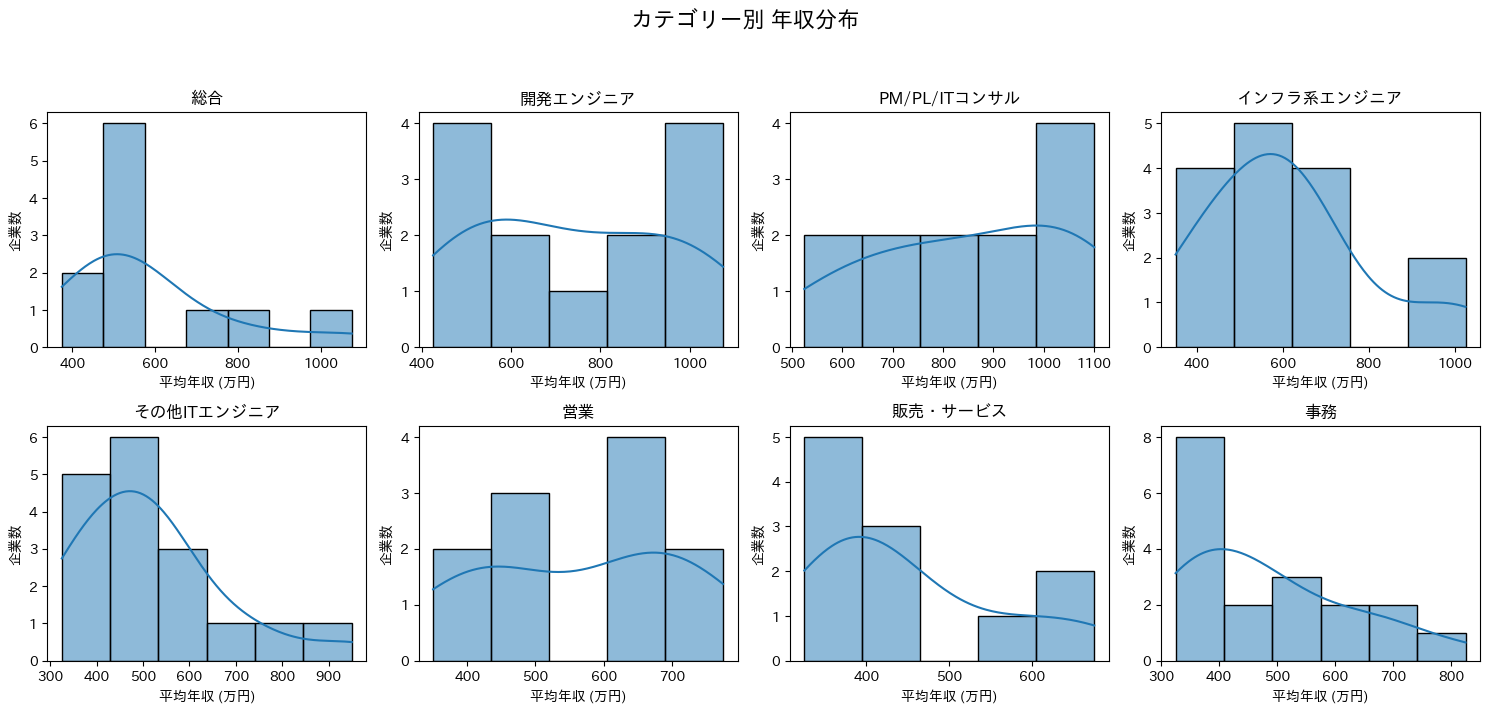

In [135]:
# カテゴリーのリストを取得
categories = df_clean['カテゴリー'].unique()

# 各カテゴリーの分布を個別にプロット
plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    plt.subplot(len(categories) // 4 + 1, 4, i + 1)
    sns.histplot(data=data_clean[data_clean['カテゴリー'] == category], x='平均年収', kde=True)
    plt.title(category)
    plt.xlabel('平均年収 (万円)')
    plt.ylabel('企業数')

# グラフのタイトルを設定
plt.suptitle('カテゴリー別 年収分布', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [136]:
# カテゴリーごとに仮定を検証
for category in categories:
    print(f'\n{category}')
    category_data = df_clean[data_clean['カテゴリー'] == category]
    correlation_results = {}
    correlation_results['設立からの年数と平均年収'] = category_data['設立からの年数'].corr(category_data['平均年収'])
    correlation_results['従業員数と平均年収'] = category_data['従業員数'].corr(category_data['平均年収'])
    correlation_results['資本金と平均年収'] = category_data['資本金'].corr(category_data['平均年収'])

    print('Correlation Results:')
    for key, value in correlation_results.items():
        print(f'{key}: {value:.2f}')


総合
Correlation Results:
設立からの年数と平均年収: 0.51
従業員数と平均年収: -0.04
資本金と平均年収: -0.26

開発エンジニア
Correlation Results:
設立からの年数と平均年収: -0.52
従業員数と平均年収: -0.26
資本金と平均年収: -0.37

PM/PL/ITコンサル
Correlation Results:
設立からの年数と平均年収: 0.49
従業員数と平均年収: 0.19
資本金と平均年収: 0.38

インフラ系エンジニア
Correlation Results:
設立からの年数と平均年収: -0.65
従業員数と平均年収: -0.54
資本金と平均年収: -0.41

その他ITエンジニア
Correlation Results:
設立からの年数と平均年収: 0.01
従業員数と平均年収: 0.19
資本金と平均年収: 0.37

営業
Correlation Results:
設立からの年数と平均年収: 0.09
従業員数と平均年収: 0.30
資本金と平均年収: 0.17

販売・サービス
Correlation Results:
設立からの年数と平均年収: -0.18
従業員数と平均年収: -0.41
資本金と平均年収: 0.42

事務
Correlation Results:
設立からの年数と平均年収: 0.33
従業員数と平均年収: 0.14
資本金と平均年収: 0.05


In [141]:
# 全体の各仮定の検証
correlation_results = {}
correlation_results['設立からの年数と平均年収'] = df_clean['設立からの年数'].corr(data_clean['平均年収'])
correlation_results['従業員数と平均年収'] = df_clean['従業員数'].corr(data_clean['平均年収'])
correlation_results['資本金と平均年収'] = df_clean['資本金'].corr(data_clean['平均年収'])

print('Correlation Results:')
for key, value in correlation_results.items():
    print(f'{key}: {value:.2f}')

Correlation Results:
設立からの年数と平均年収: -0.02
従業員数と平均年収: -0.10
資本金と平均年収: 0.24


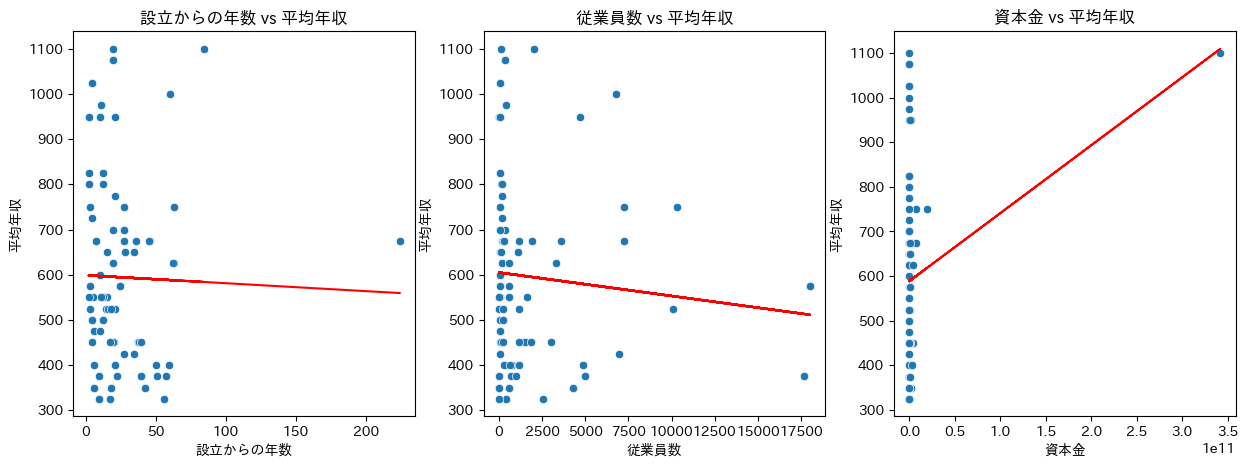

In [148]:
# 相関関係の可視化
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x='設立からの年数', y='平均年収')
plt.title('設立からの年数 vs 平均年収')
# 回帰線を追加
reg = LinearRegression()
X = df_clean['設立からの年数'].values.reshape(-1, 1)
y = df_clean['平均年収'].values
reg.fit(X, y)
plt.plot(X, reg.predict(X), color='red')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x='従業員数', y='平均年収')
plt.title('従業員数 vs 平均年収')
# 回帰線を追加
X = df_clean['従業員数'].values.reshape(-1, 1)
reg.fit(X, y)
plt.plot(X, reg.predict(X), color='red')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x='資本金', y='平均年収')
plt.title('資本金 vs 平均年収')
# 回帰線を追加
X = df_clean['資本金'].values.reshape(-1, 1)
reg.fit(X, y)
plt.plot(X, reg.predict(X), color='red')
